
# Demo 3 — Showcase AI Governance in Action with a Case Study (Local Dataset Version)

**Objective:** Demonstrate how AI governance principles — fairness audits, explainability, policy enforcement, and reporting — apply to a real-world scenario.

This notebook conforms fully to the **D03 Lab Guide**, using `adult.csv` from the **Colab session folder** instead of loading from a remote URL.


## Task 1: Set up environment and dependencies

In [ ]:

# If running in Colab or a new environment, uncomment and run this cell.
!pip install -q pandas scikit-learn shap matplotlib seaborn fairlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 45.2 MB/s eta 0:00:00



## Task 2: Load and prepare dataset

We will load the `adult.csv` file stored in the **Colab session folder** (e.g., `/content/adult.csv`).


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
import shap
from sklearn.impute import SimpleImputer

# Load data from the local Colab session folder
data_path = "/content/adult.csv"

# Define column names as the CSV does not have a header
column_names = [
    "age", "workclass", "fnlwgt", "education", "education.num",
    "marital.status", "occupation", "relationship", "race", "sex",
    "capital.gain", "capital.loss", "hours.per.week", "native.country", "income"
]

# Load data without a header and assign column names
data = pd.read_csv(data_path, header=None, names=column_names)

print("Loaded dataset shape:", data.shape)
display(data.head())

# Select relevant columns
selected_cols = ["age", "education.num", "sex", "race", "hours.per.week", "income"]
data = data[selected_cols].copy()

# Encode target and one-hot encode categoricals
data["income"] = data["income"].apply(lambda x: 1 if x.strip() == ">50K" else 0) # Added .strip() to handle potential whitespace
data = pd.get_dummies(data, drop_first=True)

# Train/test split
X = data.drop("income", axis=1)
y = data["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.head(), y.head(), X_train.shape, X_test.shape

Loaded dataset shape: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


(   age  education.num  hours.per.week  sex_ Male  race_ Asian-Pac-Islander  \
 0   39             13              40       True                     False   
 1   50             13              13       True                     False   
 2   38              9              40       True                     False   
 3   53              7              40       True                     False   
 4   28             13              40      False                     False   
 
    race_ Black  race_ Other  race_ White  
 0        False        False         True  
 1        False        False         True  
 2        False        False         True  
 3         True        False        False  
 4         True        False        False  ,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: income, dtype: int64,
 (26048, 8),
 (6513, 8))

## Task 3: Train and log a machine learning model

In [11]:

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy:.2f}")

log_df = X_test.copy()
log_df["prediction"] = predictions
log_df["actual"] = y_test.values
log_df.to_csv("model_audit_log.csv", index=False)
print("Audit log saved as model_audit_log.csv")


Model Accuracy: 0.78
Audit log saved as model_audit_log.csv


## Task 4: Perform fairness audit using Fairlearn

In [15]:
metric_frame = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=predictions,
    sensitive_features=X_test[['sex_ Male', 'race_ Other', 'race_ White', 'race_ Asian-Pac-Islander', 'race_ Black']]
)

print("Selection Rates by Group:")
display(metric_frame.by_group)

# Select the correct column for sex after one-hot encoding
sex_column = [col for col in X_test.columns if col.startswith('sex_')][0]

dp_diff = demographic_parity_difference(
    y_test, predictions, sensitive_features=X_test[sex_column]
)
print(f"Demographic Parity Difference ({sex_column.replace('sex_', '')}): {dp_diff:.3f}")

Selection Rates by Group:


sex_ Male  race_ Other  race_ White  race_ Asian-Pac-Islander  race_ Black
False      False        False        False                     False          0.074074
                                                               True           0.026756
                                     True                      False          0.116667
                                                               True                NaN
                        True         False                     False          0.061521
                                                               True                NaN
                                     True                      False               NaN
                                                               True                NaN
           True         False        False                     False          0.000000
                                                               True                NaN
                                     True                      False               NaN
                                                               True                NaN
                        True         False                     False               NaN
                                                               True                NaN
                                     True                      False               NaN
                                                               True                NaN
True       False        False        False                     False          0.045455
                                                               True           0.186667
                                     True                      False          0.345865
                                                               True                NaN
                        True         False                     False          0.256715
                                                               True                NaN
                                     True                      False               NaN
                                                               True                NaN
           True         False        False                     False          0.052632
                                                               True                NaN
                                     True                      False               NaN
                                                               True                NaN
                        True         False                     False               NaN
                                                               True                NaN
                                     True                      False               NaN
                                                               True                NaN
Name: selection_rate, dtype: float64

Demographic Parity Difference ( Male): 0.193


## Task 5: Explainability with SHAP

100%|===================| 13014/13026 [12:07<00:00]       

Feature importance for class 0


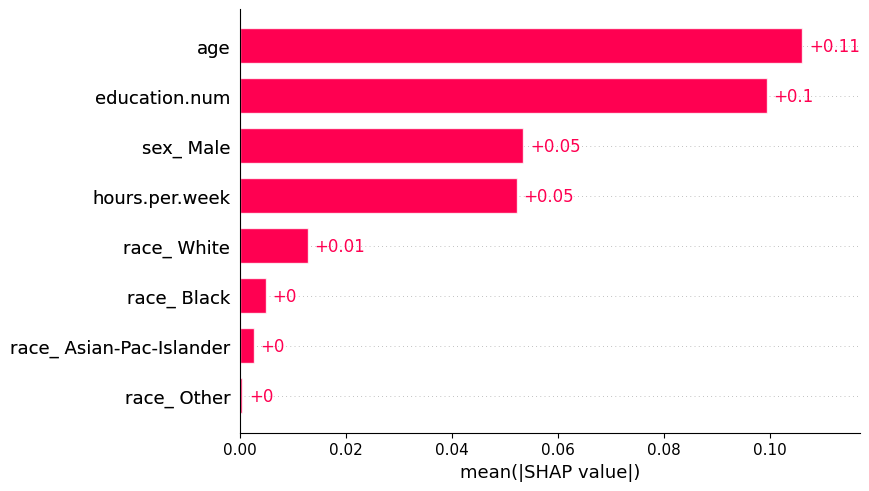

Feature importance for class 1


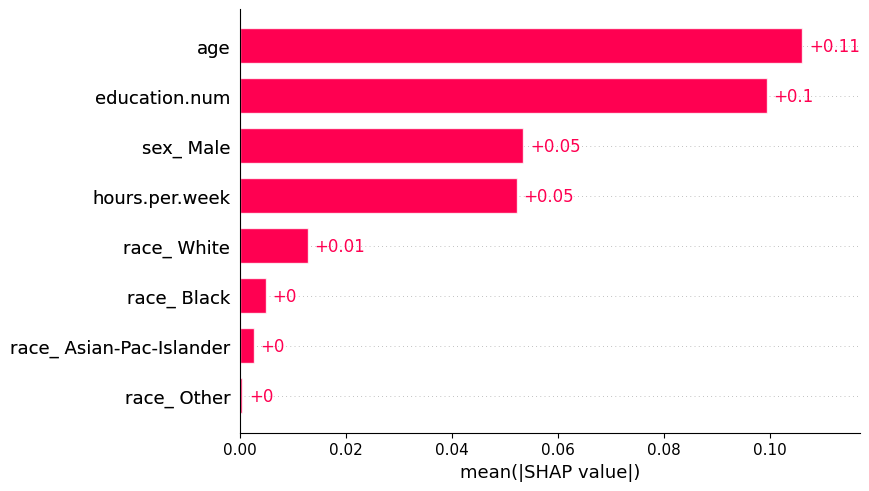

In [16]:

import numpy as np

imputer = SimpleImputer(strategy="mean")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

explainer = shap.Explainer(clf, X_train_imp)
shap_values = explainer(X_test_imp)

X_test_df = pd.DataFrame(X_test_imp, columns=X_train.columns)

for class_idx in [0, 1]:
    explanation = shap.Explanation(
        values=shap_values[:, :, class_idx],
        base_values=shap_values.base_values[:, class_idx],
        data=X_test_df,
        feature_names=X_test_df.columns
    )
    print(f"Feature importance for class {class_idx}")
    shap.plots.bar(explanation)


## Task 6: Simulate governance policy enforcement

In [17]:

if abs(dp_diff) > 0.1:
    policy_status = "Blocked"
    print("Governance Policy Triggered: Bias detected. Halting model deployment.")
else:
    policy_status = "Passed"
    print("Governance Policy Passed: Model meets fairness.")


Governance Policy Triggered: Bias detected. Halting model deployment.


## Task 7: Generate AI governance report

In [18]:

report = {
    "model": "RandomForestClassifier",
    "accuracy": accuracy,
    "dp_difference_sex": dp_diff,
    "policy_status": policy_status
}
pd.DataFrame([report]).to_csv("ai_governance_report.csv", index=False)
print("Governance report saved as ai_governance_report.csv")


Governance report saved as ai_governance_report.csv



## Final Output and Reflection
- **Organization:** GlobalTech (example)  
- **AI Use Case:** AI for Hiring  
- **Issue Identified:** Bias against female and minority candidates  
- **Tools Used:** Fairlearn, SHAP, internal audit tools  

**Reflection:**
1. How might governance policies vary by industry?
2. What actions would you take if fairness fails but explainability is strong?
3. How could these findings be reported to a governance board?
